<a href="https://colab.research.google.com/github/hypro2/hands-on-LLM-from-colab/blob/main/mmBERT_DPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentence-transformers>=5.0.0

In [1]:
from datasets import load_dataset
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
)
from sentence_transformers.evaluation import TripletEvaluator
from sentence_transformers.losses import CachedMultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers

In [2]:
lr = 8e-5
model_name = "jhu-clsp/mmBERT-small"
model_shortname = model_name.split("/")[-1]
model = SentenceTransformer(model_name)

In [3]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split

# 2. 파인튜닝에 사용할 데이터셋 로드
try:
    full_dataset = load_dataset("json", data_files="hard_train_wipsglobal_search_dataset.json", split="train")
except FileNotFoundError:
    print("데이터 파일 'hard_train_wipsglobal_search_dataset.json'을 찾을 수 없습니다.")
    exit()


# 3. 데이터셋을 학습(80%), 검증(10%), 테스트(10%)용으로 분할

# 먼저 학습용(80%)과 나머지(20%)로 분할
train_test_split = full_dataset.train_test_split(test_size=0.2, seed=42) # 재현성을 위해 seed 추가
train_dataset = train_test_split["train"]
eval_test_dataset = train_test_split["test"] # 검증+테스트 데이터

# 나머지(20%)를 다시 반으로 나누어 검증용(10%)과 테스트용(10%)으로 분할
eval_test_split = eval_test_dataset.train_test_split(test_size=0.5, seed=42)
eval_dataset = eval_test_split["train"]
test_dataset = eval_test_split["test"]


print(f"전체 데이터셋 크기: {len(full_dataset)}")
print(f"학습 데이터셋 크기: {len(train_dataset)}")
print(f"검증 데이터셋 크기: {len(eval_dataset)}")
print(f"테스트 데이터셋 크기: {len(test_dataset)}")

전체 데이터셋 크기: 15461
학습 데이터셋 크기: 12368
검증 데이터셋 크기: 1546
테스트 데이터셋 크기: 1547


In [4]:
loss = CachedMultipleNegativesRankingLoss(model, mini_batch_size=16)
run_name = f"{model_shortname}-DPR-{lr}"

args = SentenceTransformerTrainingArguments(
    output_dir=f"output/{model_shortname}/{run_name}",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.05,
    fp16=True,  # Set to False if GPU can't handle FP16
    bf16=False,  # Set to True if GPU supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,
    learning_rate=lr,
    save_strategy="steps",
    eval_strategy="steps",
    save_steps=100,
    eval_steps=100,
    logging_steps=100,
    save_total_limit=2,
    run_name=run_name,
)


In [5]:
dev_evaluator = TripletEvaluator(
    anchors=eval_dataset["query"],
    positives=eval_dataset["document"],
    negatives=eval_dataset["negative"],
    name="hard_train_wipsglobal_search_dataset",
    show_progress_bar=True,
)
dev_evaluator(model)

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

{'hard_train_wipsglobal_search_dataset_cosine_accuracy': 0.77425616979599}

In [6]:
# 6. Create a trainer & train
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=loss,
    evaluator=dev_evaluator,
)
trainer.train()



Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: Currently logged in as: hyeong9647 (hyeong9647-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W0926 04:29:14.697000 3043 torch/_inductor/utils.py:1436] [1/1] Not enough SMs to use max_autotune_gemm mode


Step,Training Loss
100,0.543700
200,0.024600
300,0.011000


TrainOutput(global_step=387, training_loss=0.15121747772823008, metrics={'train_runtime': 1473.2137, 'train_samples_per_second': 8.395, 'train_steps_per_second': 0.263, 'total_flos': 0.0, 'train_loss': 0.15121747772823008, 'epoch': 1.0})

In [8]:
dev_evaluator = TripletEvaluator(
    anchors=test_dataset["query"],
    positives=test_dataset["document"],
    negatives=test_dataset["negative"],
    name="hard_train_wipsglobal_search_dataset",
    show_progress_bar=True,
)
dev_evaluator(model)

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

{'hard_train_wipsglobal_search_dataset_cosine_accuracy': 0.9993531703948975}

In [ ]:
model.save_pretrained(f"output/{model_shortname}/{run_name}/final")
# model.push_to_hub(run_name, private=False)

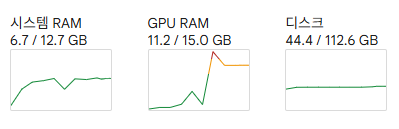